### USAGE
Plots models metrics as well as the accuracy, loss function over epochs.
- `save_plot` set to `True` will save the plot at the `plot_output_file` location.
- `save_metrics` set to `True` will load the csv file provided in `metrics_file` (or created it if doesn't exist) and append metrics (AUC, MCC, accuracy, F1-score..) in a new row in this csv file. The filename from `model_file` is used as the identifier for this row inside. To plot those metrics with all rows, use the `explore_best_models.ipynb` script.
- `save_outputs` will load the `models_outputs_path` csv and create a new column with the name `models_output_name` containing output values at test indices. Make sure the indexing of `models_outputs_path` csv is the same as test cases from the `metrics_file`, otherwise random outputs will be assign to rows from `models_output_path`.
- Once all variables are set (make sure that the path are either local or snellius path, depending on either you use vscode with ssh or not), click on "Run All".

In [1]:
import torch
import sys
sys.path.append("../4_train_models/")
from CNN.SeqBased_models import MlpRegBaseline
from CNN.datasets import Class_Seq_Dataset, create_unique_csv
import matplotlib.pylab as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import matthews_corrcoef
from torchmetrics import PrecisionRecallCurve, F1Score
import os
import pandas as pd
import pickle
from mhcflurry.regression_target import to_ic50
import numpy as np

# variables to modify
save_plot = True
save_metrics = True
save_outputs = True
models_output_path = "/projects/0/einf2380/data/external/processed/I/BA_pMHCI_human_quantitative_only_eq_models_output.csv"
models_output_name = "mlp_allele_clustered" #name of the column in the outputs csv file for this experiment
metrics_file = "/projects/0/einf2380/data/reports/metrics_csv/experiments_metrics.csv"
plot_output_file = f"/projects/0/einf2380/data/reports/figures/exp_results/{models_output_name}.svg"
graph_title = f"MLP performances using regression on clustered alleles. \n Threshold 500nM was used for binder/non binder"

models_path = "/home/lepikhovd/3D-Vac/src/4_train_models/CNN/I/classification/seq/trained_models"
model_file = f"{models_path}/mlp_classification_blosum_with_allele_encoder_500_neurons_50_epochs_exp_clustered_alleles_64_batch_size.pt"

# this is untouched
models_output_df = pd.read_csv(models_output_path)
models_output_df.set_index("ID", inplace=True)

/home/lepikhovd/anaconda3/envs/deeprank/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# useful functions:
def get_metrics(model_path):
    global save_outputs
    cp = torch.load(model_path, map_location=torch.device("cpu"))
    xval_data = cp["models_data"]
    a = cp["arguments"]
    cluster_column = (None, a.cluster_column)[a.cluster]
    if type(a.test_csv) == str:
        csv_path = create_unique_csv(a.csv_file, a.test_csv, models_output_name)
    else:
        csv_path = os.path.abspath(a.csv_file)
    dataset = Class_Seq_Dataset(
        csv_path,
        a.encoder,
        "cpu",
        threshold=a.threshold,
        cluster_column = (None, a.cluster_column)[a.cluster],
        task = "classification"
    )

    train_tpr = []
    train_losses = []
    train_tnr = []
    train_accuracies = []

    valid_tpr = []
    valid_losses = []
    valid_tnr = []
    valid_accuracies = []

    test_tpr = []
    test_losses = []
    test_tnr = []
    test_accuracies = []

    best_model_test_tprs = []
    best_model_test_tnrs = []
    best_model_test_accuracies = []

    aucs = []
    mccs = []
    # for ROCS:
    tprs = [] 
    fprs = []
    # for pr_curves
    pr_curve = PrecisionRecallCurve(task="binary")
    precisions = []
    recalls = []
    thresholds = []
    ic50_preds_all = []
    ic50_targets_all = []

    # f1 scores
    f1scores = []

    for data in xval_data:
        # load the model and data
        input_dimensions = dataset.input_shape
        model = MlpRegBaseline(neurons_per_layer=a.neurons, input_shape=input_dimensions, outputs=(1,2)[a.task=="classification"]) 
        model.load_state_dict(data["model"])
        model.eval()


        ### RETREIVE THE METRICS ###
        train_tpr.append(data["train_tpr"]);train_tnr.append(data["train_tnr"]);train_losses.append(data["train_losses"]);
        train_accuracies.append(data["train_accuracies"]);

        valid_tpr.append(data["validation_tpr"]);valid_tnr.append(data["validation_tnr"])
        valid_losses.append(data["validation_losses"]);valid_accuracies.append(data["validation_accuracies"]);

        test_tpr.append(data["test_tpr"]);test_tnr.append(data["test_tnr"]);test_losses.append(data["test_losses"]);
        test_accuracies.append(data["test_accuracies"]);

        ### MAKE THE PREDICTION ON THE TEST DATASET ###
        test_peptides = dataset.peptides[data["test_indices"]]
        test_targets = dataset.labels[data["test_indices"]]

        ic50_pred = None
        ic50_targets = None

        with torch.no_grad():
            if a.task == "classification":
                logits = torch.softmax(model(test_peptides), dim=1)
                prob = logits[:,1] 
                pred = logits.max(1)[1]
            else:
                logits = model(test_peptides)
                ic50_pred = to_ic50(np.array(logits))
                ic50_targets = to_ic50(np.array(test_targets))
                pred = torch.tensor([int(val < a.threshold) for val in ic50_pred], dtype=torch.float32)
                prob = pred
                test_targets = torch.tensor([int(val < a.threshold) for val in ic50_targets], dtype=torch.long)
            if save_outputs == True:
                test_indices = dataset.df.loc[data["test_indices"]].ID
                models_output_df.loc[test_indices, models_output_name] = ic50_pred
                models_output_df.to_csv(models_output_path)
                save_outputs = False # save only once the outputs for the given experiment, without taking all folds
        ic50_preds_all.append(ic50_pred)
        ic50_targets_all.append(ic50_targets)

        confusion = pred/test_targets # absolute values for metrics
        tot = test_targets.shape[0] # total number of prediction
        pos = float((test_targets == 1.).sum()) # total number of positives (truth 1)
        neg = float((test_targets == 0.).sum()) # total number of negatives (truth 0)

        best_model_test_tprs.append(float((confusion == 1.).sum()/pos)) # true prositive rate = prediction 1/truth 1
        best_model_test_tnrs.append(float((torch.isnan(confusion)).sum()/neg)) # true prositive rate = prediction 1/truth 1
        best_model_test_accuracies.append(float((pred==test_targets).sum()/tot))

        # roc curve
        fpr, tpr, _ = roc_curve(test_targets, prob) 
        tprs.append(tpr)
        fprs.append(fpr)

        # AUC for ROC:
        aucs.append(auc(fpr, tpr))
        # aucs.append(roc_auc_score(test_targets, prob))

        # MCC:
        mccs.append(matthews_corrcoef(test_targets, pred))

        # precision recall:
        precision, recall, thresholds = pr_curve(prob, test_targets)
        precisions.append(precision)
        recalls.append(recall)

        #f1-score
        f1_score = F1Score(task="binary")
        f1scores.append(f1_score(prob, test_targets))
    
    if a.task == "classification":
        ic50_targets_all = None
        ic50_preds_all = None

    return \
        best_model_test_tprs, best_model_test_tnrs, \
        aucs, mccs, tprs, fprs, precisions, recalls, thresholds, \
        best_model_test_accuracies, f1scores, \
        train_accuracies, valid_accuracies, test_accuracies,\
        train_tpr, valid_tpr, test_tpr,\
        train_tnr, valid_tnr, test_tnr,\
        train_losses, valid_losses, test_losses, ic50_preds_all, ic50_targets_all

def save_best_metrics(model_name, test_best_tpr, test_best_tnr, test_auc, test_mcc,
    test_best_accuracies, f1
):
    d = {
        "sensitivity_mean": [float(test_best_tpr.mean())],
        "sensitivity_std": [float(test_best_tpr.std())],
        "specificity_mean": [float(test_best_tnr.mean())],
        "specificity_std": [float(test_best_tnr.std())],
        "auc_mean": [float(test_auc.mean())],
        "auc_std": [float(test_auc.std())],
        "mcc_mean": [float(test_mcc.mean())],
        "mcc_std": [float(test_mcc.std())],
        "accuracy_mean": [float(test_best_accuracies.mean())],
        "accuracy_std": [float(test_best_accuracies.std())],
        "f1_mean": [float(f1.mean())],
        "f1_std": [float(f1.std())],
        "model_path": [model_name],
    }
    df = pd.DataFrame(d)
    metrics_csv_path = metrics_file
    if os.path.exists(metrics_csv_path):
        csv_df = pd.read_csv(metrics_csv_path)
        concat_df = pd.concat([csv_df, df])
        concat_df.to_csv(metrics_csv_path, index=False)
    else:
        df.to_csv(metrics_csv_path, index=False)

In [3]:
best_model_test_tprs, best_model_test_tnrs, \
aucs, mccs, tprs, fprs, precisions, recalls, thresholds, \
best_model_test_accuracies, f1scores, \
train_accuracies, valid_accuracies, test_accuracies, \
train_tpr, valid_tpr, test_tpr, \
train_tnr, valid_tnr, test_tnr, \
train_losses, valid_losses, test_losses, ic50_pred, ic50_targets = get_metrics(model_file)
# pickle.dump(fprs, open("fprs.pkl", "wb"))
# pickle.dump(tprs, open("tprs.pkl", "wb"))

aucs = torch.tensor(aucs)
mccs = torch.tensor(mccs)
f1scores = torch.stack(f1scores) 

best_model_test_tprs = torch.tensor(best_model_test_tprs)
best_model_test_tnrs = torch.tensor(best_model_test_tnrs)
best_model_test_accuracies = torch.tensor(best_model_test_accuracies)

train_accuracies = torch.permute(torch.tensor(train_accuracies), (1,0))
valid_accuracies = torch.permute(torch.tensor(valid_accuracies), (1,0))
test_accuracies = torch.permute(torch.tensor(test_accuracies), (1,0))

train_tpr = torch.permute(torch.tensor(train_tpr), (1,0))
valid_tpr = torch.permute(torch.tensor(valid_tpr), (1,0))
test_tpr = torch.permute(torch.tensor(test_tpr), (1,0))

train_tnr = torch.permute(torch.tensor(train_tnr), (1,0))
valid_tnr = torch.permute(torch.tensor(valid_tnr), (1,0))
test_tnr = torch.permute(torch.tensor(test_tnr).nan_to_num(), (1,0))

train_losses = torch.permute(torch.tensor(train_losses), (1,0))
valid_losses = torch.permute(torch.tensor(valid_losses), (1,0))
test_losses = torch.permute(torch.tensor(test_losses), (1,0))

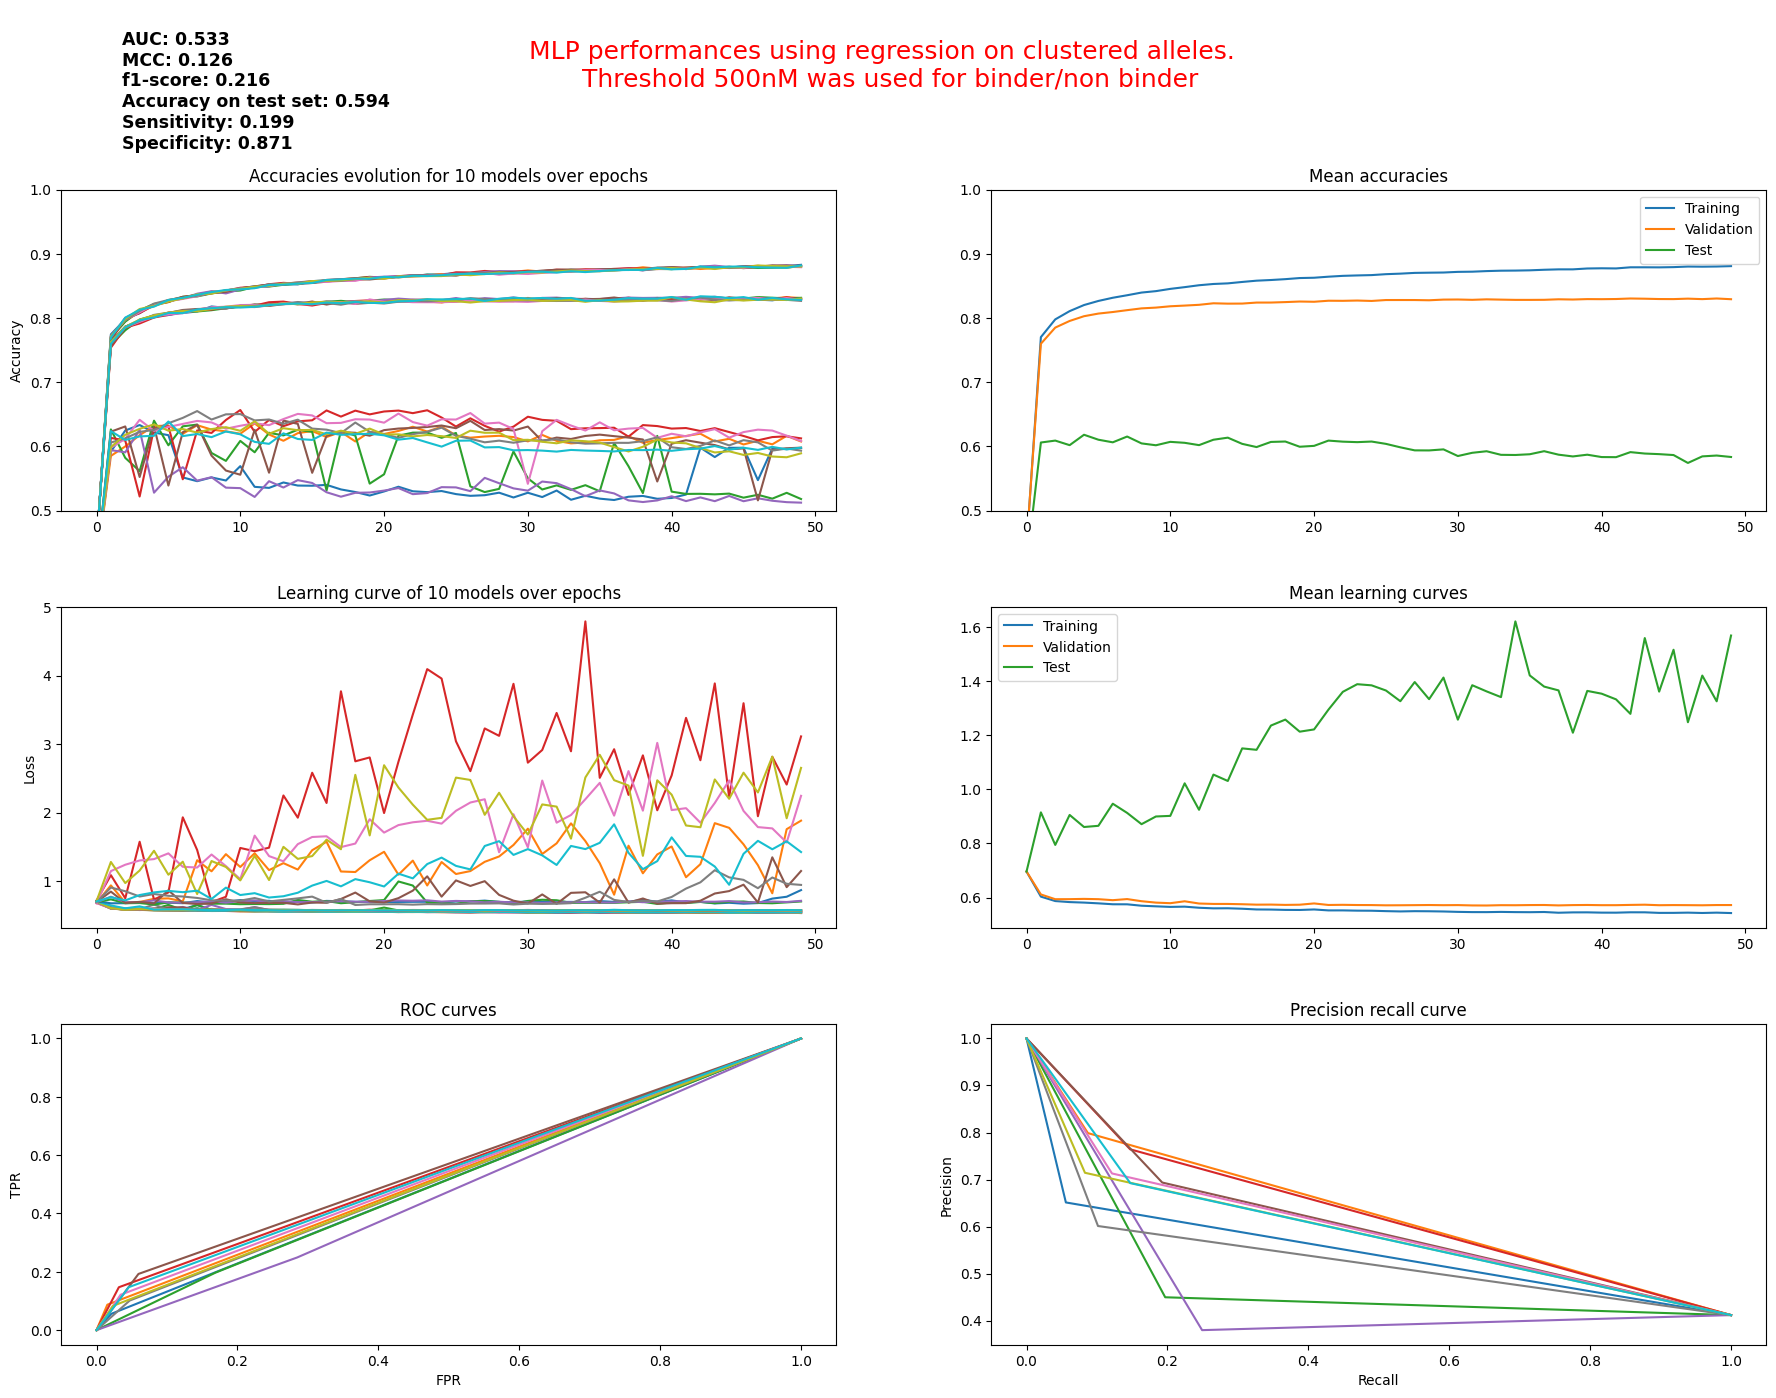

In [4]:
fig = plt.figure(figsize=(22,15))
((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)
fig.suptitle(graph_title, color="red", fontsize=18)
fig.text(
    0.15,1,
    f"\n AUC: {aucs.mean():.3} \n MCC: {mccs.mean():.3} \n f1-score: {f1scores.mean():.3} \n \
Accuracy on test set: {test_accuracies.mean():.3} \n Sensitivity: {test_tpr.mean():.3} \n Specificity: {test_tnr.mean():.3}",
    horizontalalignment="left",
    verticalalignment="top",
    fontweight=700,
    fontsize=12.5
)

e = range(train_accuracies.shape[0])

ax1.plot(e, train_accuracies)
ax1.plot(e, valid_accuracies)
ax1.plot(e, test_accuracies)
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracies evolution for 10 models over epochs")
ax1.set_ylim(0.5,1)

ax2.plot(e, train_accuracies.mean(1))
ax2.plot(e, valid_accuracies.mean(1))
ax2.plot(e, test_accuracies.mean(1))
ax2.set_title("Mean accuracies")
ax2.legend(["Training", "Validation", "Test"])
ax2.set_ylim(0.5,1)

ax3.plot(e, train_losses)
ax3.plot(e, valid_losses)
ax3.plot(e, test_losses)
ax3.set_ylabel("Loss")
ax3.set_title("Learning curve of 10 models over epochs")

ax4.plot(e, train_losses.mean(1))
ax4.plot(e, valid_losses.mean(1))
ax4.plot(e, test_losses.mean(1))
ax4.set_title("Mean learning curves")
ax4.legend(["Training", "Validation", "Test"])

#ROC
for i,tpr in enumerate(tprs):
    #ax5.plot(torch.tensor(fprs[i]).flip(dims=[0]), torch.tensor(tpr).flip(dims=[0]))
    ax5.plot(fprs[i], tprs[i])
ax5.set_title("ROC curves")
ax5.set_ylabel("TPR")
ax5.set_xlabel("FPR")

#precision-recall
for i,precision in enumerate(precisions):
    ax6.plot(recalls[i], precision)
ax6.set_title("Precision recall curve")
ax6.set_ylabel("Precision")
ax6.set_xlabel("Recall")

fig.subplots_adjust(
    wspace=.2,
    hspace=.3
)
if save_plot:
    fig.savefig(
        plot_output_file,
        transparent=False,
        facecolor="white"
    )

In [5]:
if save_metrics:
    save_best_metrics(model_file.split("/")[-1], best_model_test_tprs, best_model_test_tnrs,
        aucs, mccs, best_model_test_accuracies, f1scores
    )